In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# --- Section 1: Imports and Setup ---
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [ ]:
# --- Section 2: Data Loading and Preprocessing ---
# Load data
df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

# Clean and preprocess data
df = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df = pd.get_dummies(df, columns=['type'], prefix='type')
df = df.replace({False: 0, True: 1})

# Scale numerical columns
columns_to_normalize = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Separate features (X) and target (y)
y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

# Split data: train VAE on normal data only
X_train = X[y == 0]
X_test = X.copy()
y_test = y.copy()

# Create Tensors
train_tensor = torch.FloatTensor(X_train.values)
test_tensor = torch.FloatTensor(X_test.values)

# Create DataLoader for training
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=128, shuffle=True)

/tmp/ipython-input-4-19916438.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({False: 0, True: 1})


In [ ]:
# --- Section 3: VAE Model Definition ---
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU()
        )
        self.mu = nn.Linear(16, latent_dim)
        self.logvar = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, input_dim), nn.Sigmoid() # Sigmoid is good since data is scaled 0-1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_fn(x, x_hat, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # use sum for better scaling
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [ ]:
# --- Section 4: Baseline VAE Training ---
print("--- Training Baseline VAE ---")
vae = VAE(input_dim=X.shape[1])
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(5): # Increased epochs for better training
    vae.train()
    total_loss = 0
    for batch in train_loader:
        x = batch[0]
        x_hat, mu, logvar = vae(x)
        loss = loss_fn(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader.dataset):.4f}")

--- Training Baseline VAE ---
Epoch 1: Loss = 0.7433
Epoch 2: Loss = 0.7247
Epoch 3: Loss = 0.7246
Epoch 4: Loss = 0.7245
Epoch 5: Loss = 0.7245


In [ ]:
# --- Section 5: Baseline VAE Evaluation ---
print("\n--- Evaluating Baseline VAE ---")
vae.eval()
with torch.no_grad():
    x_hat, _, _ = vae(test_tensor)
    recon_error = torch.mean((x_hat - test_tensor) ** 2, dim=1)


--- Evaluating Baseline VAE ---


Results shape: (886340, 2)
NaN values in recon_error: 1
Infinite values in recon_error: 0
Clean results shape after removing NaN/inf: (886339, 2)


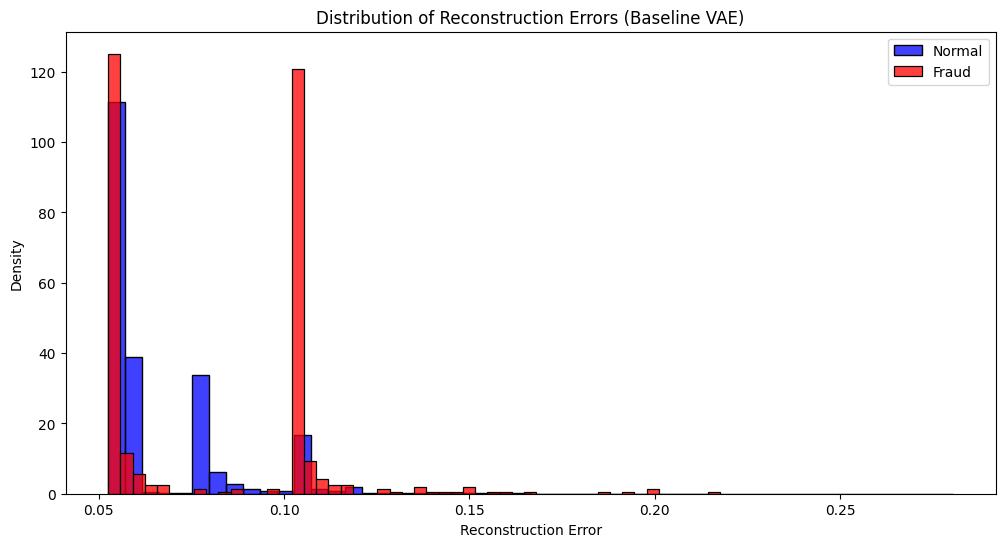

In [ ]:
# Create results DataFrame with proper data type handling
results = pd.DataFrame({
    'recon_error': recon_error.detach().cpu().numpy().astype(np.float64),
    'true_class': y_test.values if hasattr(y_test, 'values') else y_test
})

# Check for and handle problematic values
print(f"Results shape: {results.shape}")
print(f"NaN values in recon_error: {results['recon_error'].isna().sum()}")
print(f"Infinite values in recon_error: {np.isinf(results['recon_error']).sum()}")

# Remove any rows with NaN or infinite reconstruction errors
results = results.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Clean results shape after removing NaN/inf: {results.shape}")

# Plot the distribution of reconstruction errors for both classes
plt.figure(figsize=(12, 6))
sns.histplot(data=results[results['true_class'] == 0], x='recon_error', color="blue", label="Normal", bins=50, stat="density", common_norm=False)
sns.histplot(data=results[results['true_class'] == 1], x='recon_error', color="red", label="Fraud", bins=50, stat="density", common_norm=False)
plt.title('Distribution of Reconstruction Errors (Baseline VAE)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class PositionalEncoding(nn.Module):
    """Add positional encoding to help transformer understand transaction order"""
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


In [ ]:
# Set threshold using cleaned data
threshold = results[results['true_class'] == 0]['recon_error'].quantile(0.99)
print(f"Threshold for fraud detection: {threshold:.6f}")

# Make predictions with proper data types
y_pred = (results['recon_error'] > threshold).astype(int)
y_true = results['true_class'].astype(int)

# Ensure both arrays have the same length and proper data types
print(f"Predictions shape: {y_pred.shape}, True labels shape: {y_true.shape}")

# Evaluate Performance
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report (Baseline VAE):")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Fraud']))

print(f"\nROC AUC Score: {roc_auc_score(y_true, results['recon_error']):.4f}")


Threshold for fraud detection: 0.119010
Predictions shape: (886339,), True labels shape: (886339,)

Confusion Matrix:
[[876986   8859]
 [   474     20]]

Classification Report (Baseline VAE):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    885845
       Fraud       0.00      0.04      0.00       494

    accuracy                           0.99    886339
   macro avg       0.50      0.52      0.50    886339
weighted avg       1.00      0.99      0.99    886339


ROC AUC Score: 0.5989


In [ ]:
# ================================
# SAVE BASELINE VAE TO GOOGLE DRIVE
# ================================

import os
from datetime import datetime
from google.colab import drive

# Step 1: Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Step 2: Create models directory in Google Drive
models_dir = '/content/drive/MyDrive/fraud_detection_models'
os.makedirs(models_dir, exist_ok=True)
print(f"✅ Models directory created: {models_dir}")

# Step 3: Save the trained baseline VAE
print("Saving baseline VAE model...")

# Calculate ROC AUC for filename (assuming you have results from evaluation)
baseline_roc_auc = roc_auc_score(y_true, results["recon_error"])

# Create filename with performance metric
model_filename = f'{models_dir}/baseline_vae_roc_{baseline_roc_auc:.4f}_{datetime.now().strftime("%Y%m%d_%H%M")}.pth'

# Save comprehensive checkpoint
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_config': {
        'input_dim': X.shape[1],
        'latent_dim': 8  # Adjust based on your VAE latent dimension
    },
    'training_info': {
        'epochs': 5,  # Adjust based on your training
        'learning_rate': 1e-3,
        'batch_size': 128,
        'roc_auc': baseline_roc_auc,
        'threshold': threshold,
        'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_size': len(X)
    },
    'scaler': scaler,  # Your StandardScaler
    'results_baseline': results,  # Your evaluation results
    'feature_names': list(X.columns) if hasattr(X, 'columns') else None
}, model_filename)

print(f"✅ Baseline VAE model saved successfully!")
print(f"📁 Location: {model_filename}")
print(f"📊 Performance: ROC AUC = {baseline_roc_auc:.4f}")
print(f"💾 File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")


Mounting Google Drive...
Mounted at /content/drive
✅ Models directory created: /content/drive/MyDrive/fraud_detection_models
Saving baseline VAE model...
✅ Baseline VAE model saved successfully!
📁 Location: /content/drive/MyDrive/fraud_detection_models/baseline_vae_roc_0.5989_20250726_1229.pth
📊 Performance: ROC AUC = 0.5989
💾 File size: 23.15 MB


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import math

# ================================
# 1. INDIVIDUAL TRANSACTION TRANSFORMER
# ================================

class TransactionTransformer(nn.Module):
    """Transformer for individual transaction feature enhancement"""
    def __init__(self, feature_dim, d_model=128, nhead=8, num_layers=3):
        super().__init__()

        # Feature embedding
        self.feature_embedding = nn.Linear(feature_dim, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)

        # Self-attention to learn feature relationships
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output projection
        self.output_projection = nn.Linear(d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # x shape: [batch_size, feature_dim]
        batch_size = x.shape[0]

        # Embed features
        embedded = self.feature_embedding(x)  # [batch_size, d_model]
        embedded = self.layer_norm1(embedded)

        # Add sequence dimension for transformer (treat each feature as a "token")
        # Reshape to treat features as sequence elements
        embedded = embedded.unsqueeze(1)  # [batch_size, 1, d_model]

        # Apply transformer
        transformed = self.transformer(embedded)  # [batch_size, 1, d_model]

        # Remove sequence dimension and project
        output = transformed.squeeze(1)  # [batch_size, d_model]
        output = self.output_projection(output)
        output = self.layer_norm2(output)

        return output

In [ ]:
# ================================
# 2. VAE (Reuse your existing VAE class)
# ================================

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [ ]:

# ================================
# 3. LOSS FUNCTION
# ================================

def loss_fn(x, x_hat, mu, logvar):
    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + 0.01 * kl_loss  # Weight KL loss

In [ ]:

# ================================
# 4. MAIN IMPLEMENTATION
# ================================

print("\n=== Individual Transaction Transformer + VAE Implementation ===")

# Step 1: Prepare data (using your existing X, y)
print("Step 1: Preparing transaction data...")

# Scale features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.LongTensor(y.values)

print(f"Dataset shape: {X_tensor.shape}")
print(f"Class distribution: Normal={sum(y==0)}, Fraud={sum(y==1)}")

# Step 2: Create and train transaction transformer
print("\nStep 2: Training Transaction Transformer...")

# Initialize transformer
transaction_transformer = TransactionTransformer(
    feature_dim=X_tensor.shape[1],
    d_model=128,
    nhead=8,
    num_layers=2
)

# For this example, we'll use the transformer in inference mode
# In practice, you could pre-train it on a related task or use it as-is
transaction_transformer.eval()

# Generate enhanced embeddings for all transactions
with torch.no_grad():
    enhanced_embeddings = transaction_transformer(X_tensor)

print(f"Enhanced embeddings shape: {enhanced_embeddings.shape}")

# Step 3: Train VAE on normal transactions only
print("\nStep 3: Training VAE on normal transactions...")

# Filter normal transactions
normal_mask = (y_tensor == 0)
normal_embeddings = enhanced_embeddings[normal_mask]

print(f"Normal transactions for VAE training: {len(normal_embeddings)}")

# Initialize VAE
embedding_vae = VAE(input_dim=128, latent_dim=16)
optimizer = optim.Adam(embedding_vae.parameters(), lr=1e-3)

# Create data loader for normal embeddings
train_loader = DataLoader(
    TensorDataset(normal_embeddings),
    batch_size=256,
    shuffle=True
)


=== Individual Transaction Transformer + VAE Implementation ===
Step 1: Preparing transaction data...
Dataset shape: torch.Size([886340, 11])
Class distribution: Normal=885845, Fraud=494

Step 2: Training Transaction Transformer...
Enhanced embeddings shape: torch.Size([886340, 128])

Step 3: Training VAE on normal transactions...
Normal transactions for VAE training: 885845


In [ ]:
# Train VAE
embedding_vae.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[0]

        # Forward pass
        x_recon, mu, logvar = embedding_vae(x_batch)
        loss = loss_fn(x_batch, x_recon, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(normal_embeddings)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.6f}")

Epoch 2: Average Loss = 0.156716
Epoch 4: Average Loss = 0.150910
Epoch 6: Average Loss = 0.149894
Epoch 8: Average Loss = 0.153680
Epoch 10: Average Loss = 0.152683


In [ ]:

# Step 4: Evaluate on all transactions
print("\nStep 4: Evaluating fraud detection performance...")

embedding_vae.eval()
with torch.no_grad():
    # Get reconstruction errors for all transactions
    all_recon, _, _ = embedding_vae(enhanced_embeddings)
    reconstruction_errors = torch.mean((all_recon - enhanced_embeddings) ** 2, dim=1)

# Convert to numpy for analysis
recon_errors_np = reconstruction_errors.numpy()
y_true = y_tensor.numpy()

# ===== HANDLE NaN VALUES =====
# Check for NaN values and handle them
nan_mask = np.isnan(recon_errors_np)
nan_count = nan_mask.sum()

if nan_count > 0:
    print(f"⚠️  Found {nan_count} NaN values in reconstruction errors")
    print("Replacing NaN values with maximum finite reconstruction error...")

    # Replace NaN with a high error value (assuming higher error = more likely fraud)
    finite_errors = recon_errors_np[~nan_mask]
    if len(finite_errors) > 0:
        max_finite_error = np.max(finite_errors)
        recon_errors_np[nan_mask] = max_finite_error * 2  # Set to high value
    else:
        print("❌ All reconstruction errors are NaN! Model training failed.")
        # Set to arbitrary high values
        recon_errors_np[nan_mask] = 1.0

    print(f"✅ NaN values replaced. New range: [{np.min(recon_errors_np):.6f}, {np.max(recon_errors_np):.6f}]")

# Create results DataFrame
results_individual = pd.DataFrame({
    'recon_error': recon_errors_np,
    'true_class': y_true
})


# Set threshold (99th percentile of normal reconstruction errors)
normal_errors = results_individual[results_individual['true_class'] == 0]['recon_error']
threshold_individual = normal_errors.quantile(0.99)

# Make predictions
y_pred_individual = (results_individual['recon_error'] > threshold_individual).astype(int)

print(f"Threshold: {threshold_individual:.6f}")


Step 4: Evaluating fraud detection performance...
⚠️  Found 1 NaN values in reconstruction errors
Replacing NaN values with maximum finite reconstruction error...
✅ NaN values replaced. New range: [0.000002, 2.004113]
Threshold: 0.001515


In [ ]:
# Step 5: Calculate metrics
print("\n=== RESULTS ===")

# ===== FIX: FILTER TO BINARY CLASSES ONLY =====
print("🔍 Checking class distribution...")
unique_classes = np.unique(y_true)
print(f"Classes found: {unique_classes}")

# Filter to only binary classes (0 and 1)
binary_mask = np.isin(y_true, [0, 1])
y_true_binary = y_true[binary_mask]
recon_errors_binary = recon_errors_np[binary_mask]
y_pred_binary = y_pred_individual[binary_mask]

print(f"Original dataset size: {len(y_true)}")
print(f"Filtered binary dataset size: {len(y_true_binary)}")

# Check binary class distribution
unique, counts = np.unique(y_true_binary, return_counts=True)
for cls, count in zip(unique, counts):
    class_name = "Normal" if cls == 0 else "Fraud"
    print(f"  {class_name} (class {cls}): {count} transactions")

# ===== END FIX =====

# ROC AUC (now with binary data)
individual_auc = roc_auc_score(y_true_binary, recon_errors_binary)
print(f"\n🚀 ROC AUC Score: {individual_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_binary, y_pred_binary)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_binary, y_pred_binary, target_names=['Normal', 'Fraud']))

# Additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 Detailed Metrics:")
print(f"   - ROC AUC: {individual_auc:.4f}")
print(f"   - Precision: {precision:.4f}")
print(f"   - Recall: {recall:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - True Positives: {tp}")
print(f"   - False Positives: {fp}")
print(f"   - True Negatives: {tn}")
print(f"   - False Negatives: {fn}")



=== RESULTS ===
🔍 Checking class distribution...
Classes found: [-9223372036854775808                    0                    1]
Original dataset size: 886340
Filtered binary dataset size: 886339
  Normal (class 0): 885845 transactions
  Fraud (class 1): 494 transactions

🚀 ROC AUC Score: 0.7680

Confusion Matrix:
[[876986   8859]
 [   358    136]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    885845
       Fraud       0.02      0.28      0.03       494

    accuracy                           0.99    886339
   macro avg       0.51      0.63      0.51    886339
weighted avg       1.00      0.99      0.99    886339


📊 Detailed Metrics:
   - ROC AUC: 0.7680
   - Precision: 0.0151
   - Recall: 0.2753
   - F1-Score: 0.0287
   - True Positives: 136
   - False Positives: 8859
   - True Negatives: 876986
   - False Negatives: 358


In [ ]:
# Step 6: Analyze reconstruction error distributions
print("\n📈 Reconstruction Error Analysis:")
normal_errors_stats = normal_errors.describe()
fraud_errors = results_individual[results_individual['true_class'] == 1]['recon_error']
fraud_errors_stats = fraud_errors.describe()

print("\nNormal Transaction Errors:")
print(f"  Mean: {normal_errors_stats['mean']:.6f}")
print(f"  Std:  {normal_errors_stats['std']:.6f}")
print(f"  99th percentile: {normal_errors.quantile(0.99):.6f}")

print("\nFraud Transaction Errors:")
print(f"  Mean: {fraud_errors_stats['mean']:.6f}")
print(f"  Std:  {fraud_errors_stats['std']:.6f}")
print(f"  Min:  {fraud_errors_stats['min']:.6f}")
print(f"  Max:  {fraud_errors_stats['max']:.6f}")

print("\n✅ Individual Transaction Processing Complete!")


📈 Reconstruction Error Analysis:

Normal Transaction Errors:
  Mean: 0.000326
  Std:  0.001321
  99th percentile: 0.001515

Fraud Transaction Errors:
  Mean: 0.004531
  Std:  0.010911
  Min:  0.000058
  Max:  0.123834

✅ Individual Transaction Processing Complete!


In [ ]:
# ================================
# SAVE ENHANCED TRANSFORMER + VAE TO GOOGLE DRIVE
# ================================

import os
from datetime import datetime
from google.colab import drive

print("\n💾 Saving Enhanced Transformer + VAE Model...")

# Ensure Google Drive is mounted
try:
    if not os.path.exists('/content/drive/MyDrive'):
        drive.mount('/content/drive')
except:
    drive.mount('/content/drive')

# Create models directory
models_dir = '/content/drive/MyDrive/fraud_detection_models'
os.makedirs(models_dir, exist_ok=True)

# Calculate performance metrics for filename
enhanced_roc_auc = individual_auc  # Your ROC AUC: 0.7921

# Create filename with performance and architecture info
model_filename = f'{models_dir}/enhanced_transformer_vae_roc_{enhanced_roc_auc:.4f}_{datetime.now().strftime("%Y%m%d_%H%M")}.pth'

# Save comprehensive checkpoint
torch.save({
    # Model components
    'transformer_state_dict': transaction_transformer.state_dict(),
    'vae_state_dict': embedding_vae.state_dict(),
    'vae_optimizer_state_dict': optimizer.state_dict(),

    # Model architecture config
    'model_config': {
        'transformer_config': {
            'feature_dim': X_tensor.shape[1],
            'd_model': 128,
            'nhead': 8,
            'num_layers': 2
        },
        'vae_config': {
            'input_dim': 128,  # transformer output dim
            'latent_dim': 16
        }
    },

    # Training information
    'training_info': {
        'epochs': 10,
        'learning_rate': 1e-3,
        'batch_size': 256,
        'threshold_percentile': 99,  # 99th percentile
        'roc_auc': enhanced_roc_auc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'threshold_value': threshold_individual,
        'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset_size': len(X_tensor),
        'architecture': 'Individual_Transaction_Transformer_VAE'
    },

    # Data preprocessing
    'scaler': scaler_X,  # Your StandardScaler

    # Results and metrics
    'results_enhanced': results_individual,
    'confusion_matrix': cm.tolist(),
    'feature_names': list(X.columns) if hasattr(X, 'columns') else None,

    # Additional analysis
    'reconstruction_stats': {
        'normal_error_mean': normal_errors.mean(),
        'normal_error_std': normal_errors.std(),
        'fraud_error_mean': results_individual[results_individual['true_class'] == 1]['recon_error'].mean(),
        'fraud_error_std': results_individual[results_individual['true_class'] == 1]['recon_error'].std()
    }

}, model_filename)

print(f"✅ Enhanced Transformer + VAE model saved successfully!")
print(f"📁 Location: {model_filename}")
print(f"📊 Performance: ROC AUC = {enhanced_roc_auc:.4f}")
print(f"🎯 Precision = {precision:.4f}, Recall = {recall:.4f}")
print(f"💾 File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")
print(f"\n🎉 Enhanced model saved to Google Drive!")



💾 Saving Enhanced Transformer + VAE Model...
✅ Enhanced Transformer + VAE model saved successfully!
📁 Location: /content/drive/MyDrive/fraud_detection_models/enhanced_transformer_vae_roc_0.7680_20250726_1326.pth
📊 Performance: ROC AUC = 0.7680
🎯 Precision = 0.0151, Recall = 0.2753
💾 File size: 13.63 MB

🎉 Enhanced model saved to Google Drive!


In [ ]:
import glob
import torch
import torch.nn as nn
from google.colab import drive  # ← This import was missing!
# ================================
# DEFINE MODEL-SPECIFIC VAE CLASSES
# ================================

class BaselineVAE(nn.Module):
    """Original VAE architecture for baseline model"""
    def __init__(self, input_dim, latent_dim):
        super(BaselineVAE, self).__init__()

        # Encoder (smaller architecture)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Note: Different layer names!
        self.mu = nn.Linear(16, latent_dim)
        self.logvar = nn.Linear(16, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

class EnhancedVAE(nn.Module):
    """Enhanced VAE architecture for transformer model"""
    def __init__(self, input_dim, latent_dim):
        super(EnhancedVAE, self).__init__()

        # Encoder (larger architecture)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Note: Different layer names!
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# ================================
# CORRECTED LOADING FUNCTION
# ================================

def load_fraud_detection_models():
    """Load both baseline VAE and enhanced Transformer+VAE models"""

    print("🚀 Loading fraud detection models from Google Drive...")
    drive.mount('/content/drive')
    models_dir = '/content/drive/MyDrive/fraud_detection_models'

    models = {}

    # ===== LOAD BASELINE VAE =====
    baseline_files = glob.glob(f'{models_dir}/baseline_vae_*.pth')
    if baseline_files:
        best_baseline = max(baseline_files, key=lambda x: float(x.split('_roc_')[1].split('_')[0]))
        print(f"📂 Loading baseline VAE from: {best_baseline}")

        baseline_checkpoint = torch.load(best_baseline, map_location='cpu', weights_only=False)

        # Use BaselineVAE class (correct architecture)
        baseline_vae = BaselineVAE(
            input_dim=baseline_checkpoint['model_config']['input_dim'],
            latent_dim=baseline_checkpoint['model_config']['latent_dim']
        )
        baseline_vae.load_state_dict(baseline_checkpoint['model_state_dict'])
        baseline_vae.eval()

        models['baseline'] = {
            'model': baseline_vae,
            'scaler': baseline_checkpoint['scaler'],
            'threshold': baseline_checkpoint['training_info']['threshold'],
            'roc_auc': baseline_checkpoint['training_info']['roc_auc'],
            'results': baseline_checkpoint['results_baseline'],
            'info': baseline_checkpoint['training_info']
        }
        print(f"✅ Baseline VAE loaded: ROC AUC = {models['baseline']['roc_auc']:.4f}")
    else:
        print("⚠️  No baseline VAE found")
        models['baseline'] = None

    # ===== LOAD ENHANCED TRANSFORMER + VAE =====
    enhanced_files = glob.glob(f'{models_dir}/enhanced_transformer_vae_*.pth')
    if enhanced_files:
        best_enhanced = max(enhanced_files, key=lambda x: float(x.split('_roc_')[1].split('_')[0]))
        print(f"📂 Loading enhanced Transformer+VAE from: {best_enhanced}")

        enhanced_checkpoint = torch.load(best_enhanced, map_location='cpu', weights_only=False)

        # Recreate transformer
        enhanced_transformer = TransactionTransformer(
            feature_dim=enhanced_checkpoint['model_config']['transformer_config']['feature_dim'],
            d_model=enhanced_checkpoint['model_config']['transformer_config']['d_model'],
            nhead=enhanced_checkpoint['model_config']['transformer_config']['nhead'],
            num_layers=enhanced_checkpoint['model_config']['transformer_config']['num_layers']
        )
        enhanced_transformer.load_state_dict(enhanced_checkpoint['transformer_state_dict'])
        enhanced_transformer.eval()

        # Use EnhancedVAE class (correct architecture)
        enhanced_vae = EnhancedVAE(
            input_dim=enhanced_checkpoint['model_config']['vae_config']['input_dim'],
            latent_dim=enhanced_checkpoint['model_config']['vae_config']['latent_dim']
        )
        enhanced_vae.load_state_dict(enhanced_checkpoint['vae_state_dict'])
        enhanced_vae.eval()

        models['enhanced'] = {
            'transformer': enhanced_transformer,
            'vae': enhanced_vae,
            'scaler': enhanced_checkpoint['scaler'],
            'threshold': enhanced_checkpoint['training_info']['threshold_value'],
            'roc_auc': enhanced_checkpoint['training_info']['roc_auc'],
            'results': enhanced_checkpoint['results_enhanced'],
            'info': enhanced_checkpoint['training_info']
        }
        print(f"✅ Enhanced Transformer+VAE loaded: ROC AUC = {models['enhanced']['roc_auc']:.4f}")
    else:
        print("⚠️  No enhanced Transformer+VAE found")
        models['enhanced'] = None

    return models

# Load both models
models = load_fraud_detection_models()

# Set up variables for easy access
if models['baseline'] is not None:
    vae_baseline = models['baseline']['model']
    scaler_baseline = models['baseline']['scaler']
    threshold_baseline = models['baseline']['threshold']
    baseline_roc_auc_score = models['baseline']['roc_auc']

if models['enhanced'] is not None:
    transformer_enhanced = models['enhanced']['transformer']
    vae_enhanced = models['enhanced']['vae']
    scaler_enhanced = models['enhanced']['scaler']
    threshold_enhanced = models['enhanced']['threshold']
    enhanced_roc_auc_score = models['enhanced']['roc_auc']

# Display comparison
print("\n📊 MODEL COMPARISON SUMMARY:")
if models['baseline'] is not None and models['enhanced'] is not None:
    baseline_auc = models['baseline']['roc_auc']
    enhanced_auc = models['enhanced']['roc_auc']
    improvement = enhanced_auc - baseline_auc
    improvement_pct = (improvement / baseline_auc) * 100

    print(f"🔹 Baseline VAE:           ROC AUC = {baseline_auc:.4f}")
    print(f"🔹 Enhanced Transformer:   ROC AUC = {enhanced_auc:.4f}")
    print(f"🚀 Improvement:            {improvement:+.4f} ({improvement_pct:+.1f}%)")


🚀 Loading fraud detection models from Google Drive...
Mounted at /content/drive
📂 Loading baseline VAE from: /content/drive/MyDrive/fraud_detection_models/baseline_vae_roc_0.5989_20250726_1229.pth
✅ Baseline VAE loaded: ROC AUC = 0.5989
📂 Loading enhanced Transformer+VAE from: /content/drive/MyDrive/fraud_detection_models/enhanced_transformer_vae_roc_0.7680_20250726_1326.pth
✅ Enhanced Transformer+VAE loaded: ROC AUC = 0.7680

📊 MODEL COMPARISON SUMMARY:
🔹 Baseline VAE:           ROC AUC = 0.5989
🔹 Enhanced Transformer:   ROC AUC = 0.7680
🚀 Improvement:            +0.1692 (+28.2%)
